<a href="https://colab.research.google.com/github/mustafa-cpu-pr/Satellite-Disaster-Prediction-System/blob/main/Satellite_Disaster_Prediction_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) FLOOD DETECTION :-  
   Predicting the chances of flood occuring before it actually occured in Sylhet,Bangladesh using satellite images of Surma river and nearby water bodies fetched using Nasa API also supporting the machine learning prediction model by providing it with a csv file for dataset including information about surma river levels before the flood date,rainfal(in mm) and Soil moisture Condition. Using the csv file for visulation of rainfall and river levels to identify flood trends and then training the csv data and image data to predict chances of flood occuring then displaying it through chart and flood overlay image


📍 Location: https://www.google.com/maps?q=24.89,91.88
Satellite Image URL: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/acccc718f39fd76c6a0c9576faf452b1-86949dc5df485134a952191cf51be940:getPixels


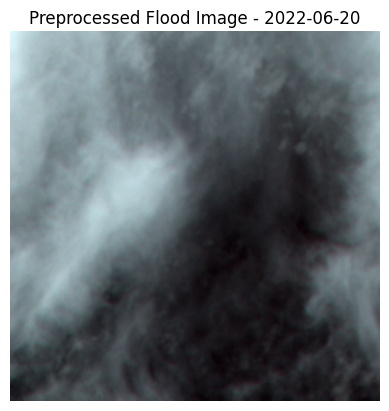

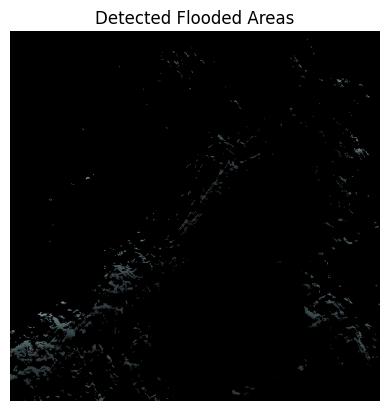

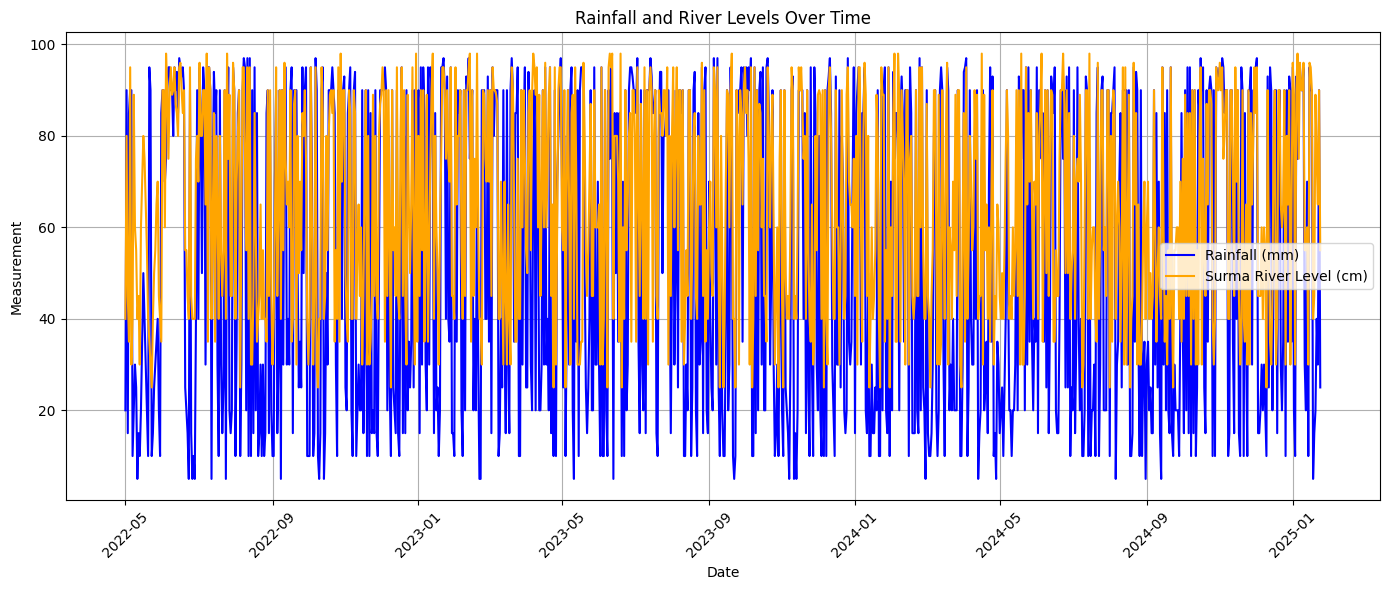

Model Accuracy: 0.91
Confusion Matrix:
[[ 72  11]
 [  7 110]]


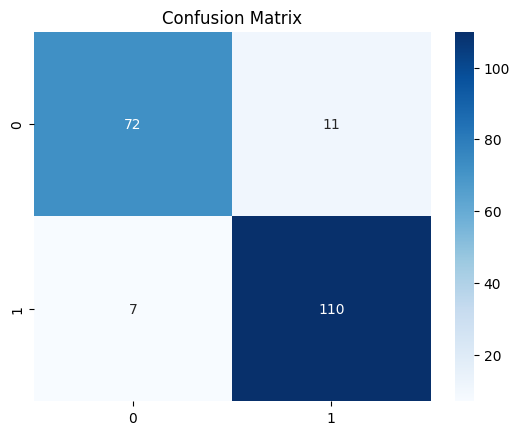

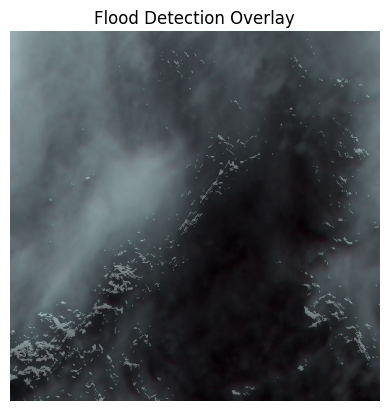

Estimated Chance of Flooding: 60.50%
Message sent to 919004279309  successfully.


In [44]:
import requests
import json
import random
import datetime
import os
from sendgrid import SendGridAPIClient
from sendgrid.helpers.mail import Mail
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from IPython.display import display, HTML
from google.colab import files
from vonage import Vonage, Auth
from vonage_sms import SmsMessage

#uploaded = files.upload()
df = pd.read_csv('extended_flood_data.csv')

NASA_API_KEY = '2gq990VUavPLf9uQqDBEdKR3XpTDqDxlPCekpaGr'
longitude = 91.88
latitude = 24.89
date = '2022-06-20'
print(f"📍 Location: https://www.google.com/maps?q={latitude},{longitude}")
# current_date = datetime.datetime.now().strftime('%Y-%m-%d')
dim = 0.1
url = "https://api.nasa.gov/planetary/earth/assets"
params = {
    'lon': longitude,
    'lat': latitude,
    'date': date,
    'dim': dim,
    'api_key': NASA_API_KEY
}

response = requests.get(url, params=params)
if response.status_code == 200:
    data = response.json()
    image_url = data.get('url')
    if image_url:
        print("Satellite Image URL:", image_url)
        try:
            image_response = requests.get(image_url)
            image_response.raise_for_status()
            image = Image.open(BytesIO(image_response.content))
            image = np.array(image)
            image_resized = cv2.resize(image, (512, 512))
            image_blurred = cv2.GaussianBlur(image_resized, (5, 5), 0)
            image_normalized = cv2.normalize(image_blurred, None, 0, 255, cv2.NORM_MINMAX)
            plt.imshow(cv2.cvtColor(image_normalized, cv2.COLOR_BGR2RGB))
            plt.title(f"Preprocessed Flood Image - {date}")
            plt.axis('off')
            plt.show()
            hsv_image = cv2.cvtColor(image_normalized, cv2.COLOR_BGR2HSV)
            lower_blue = np.array([90, 50, 50])
            upper_blue = np.array([130, 255, 255])
            flood_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)
            flood_result = cv2.bitwise_and(image_normalized, image_normalized, mask=flood_mask)
            plt.imshow(cv2.cvtColor(flood_result, cv2.COLOR_BGR2RGB))
            plt.title('Detected Flooded Areas')
            plt.axis('off')
            plt.show()
            plt.figure(figsize=(14, 6))
            plt.plot(pd.to_datetime(df['Date']), df['Rainfall (mm)'], label='Rainfall (mm)', color='blue')
            plt.plot(pd.to_datetime(df['Date']), df['Surma River Level(cm above danger line)'], label='Surma River Level (cm)', color='orange')
            plt.title('Rainfall and River Levels Over Time')
            plt.xlabel('Date')
            plt.ylabel('Measurement')
            plt.legend()
            plt.grid()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            df = pd.get_dummies(df, columns=['Soil Moisture Condition'], drop_first=True)
            # df['Flood'] = np.where((df['Rainfall (mm)'] > 60) | (df['Surma River Level(cm above danger line)'] > 60), 1, 0)
            df['Flood'] = np.where((df['Rainfall (mm)'] > 60) | (df['Surma River Level(cm above danger line)'] > 60), 1, 0)
            noise_fraction = 0.1
            n_samples = int(noise_fraction * len(df))
            flip_indices = random.sample(range(len(df)), n_samples)
            df.loc[flip_indices, 'Flood'] = 1 - df.loc[flip_indices, 'Flood']
            X = df[['Rainfall (mm)', 'Surma River Level(cm above danger line)'] + list(df.columns[df.columns.str.contains('Soil Moisture Condition_')])]
            y = df['Flood']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            print('Model Accuracy:', accuracy)
            cm = confusion_matrix(y_test, y_pred)
            print('Confusion Matrix:')
            print(cm)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.show()
            overlay = cv2.addWeighted(image_normalized, 0.7, cv2.cvtColor(flood_mask, cv2.COLOR_GRAY2BGR), 0.3, 0)
            plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
            plt.title('Flood Detection Overlay')
            plt.axis('off')
            plt.show()
            flood_chance = model.predict(X_test)
            flood_chance_percentage = np.mean(flood_chance) * 100
            print(f"Estimated Chance of Flooding: {flood_chance_percentage:.2f}%")
            if flood_chance_percentage > 50:
              auth = Auth(api_key="83ca0e9e", api_secret="ARQaTJ67DBeO1Uuv")


              client = Vonage(auth=auth)

              to = "919004279309"
              message = SmsMessage(
                  to=to,
                  from_="Vonage APIs",
                  text=" Flood Alert: A disaster has been predicted in your area. Stay alert and follow official evacuation instructions."
              )

              response = client.sms.send(message)

              if response.messages[0].status == "0":
                  print(f"Message sent to {to}  successfully.")
              else:
                  print(f" Message failed with error: {response.messages[0].error_text}")
              evacuation_url = "https://www.ready.gov/evacuation"
              display(HTML(f'<script>window.open("{evacuation_url}", "_blank");</script>'))
        except Exception as e:
            print(f"Error displaying the image: {e}")
    else:
        print("No image available for the given location and date.")
else:
    print(f"Failed to fetch data from NASA API. Status code: {response.status_code}")


 Flood Detection using Support Vector Machine

📍 Location: https://www.google.com/maps?q=24.89,91.88
Satellite Image URL: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/acccc718f39fd76c6a0c9576faf452b1-864ddd07097e382199acf1a018b128c6:getPixels
📍 Location: https://www.google.com/maps?q=24.89,91.88


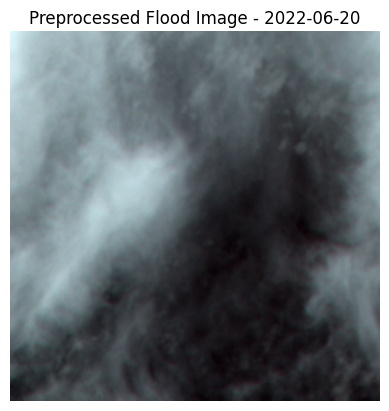

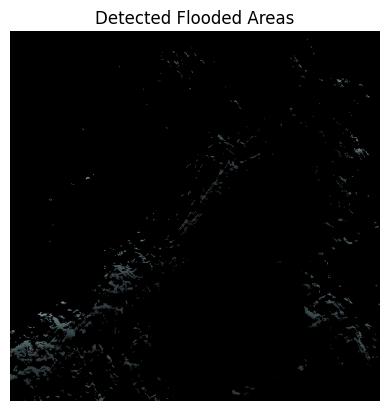

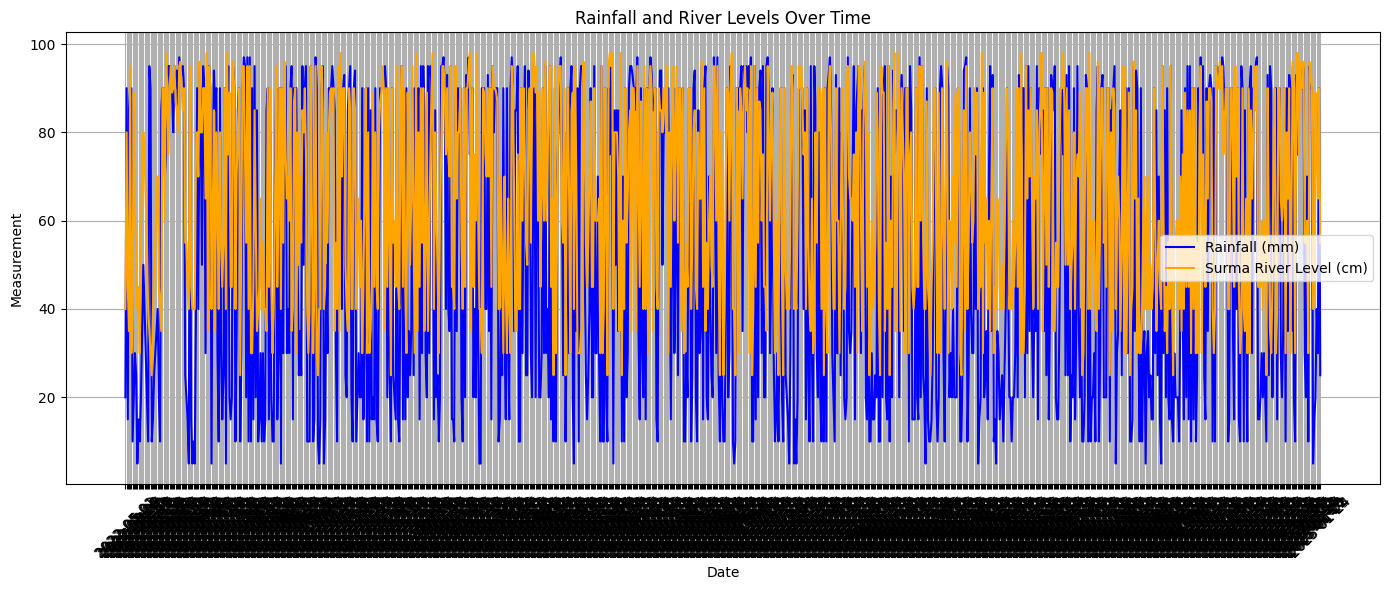

Model Accuracy (SVM): 0.905
Confusion Matrix:
[[ 74  10]
 [  9 107]]


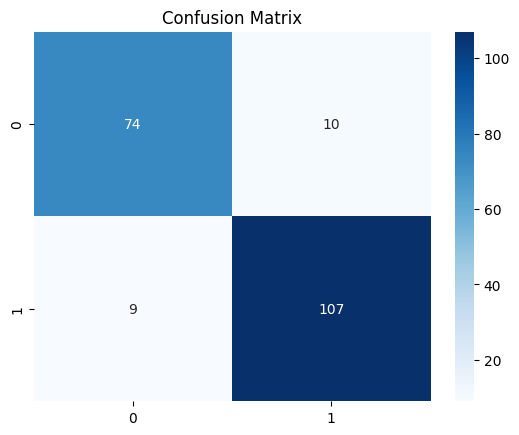

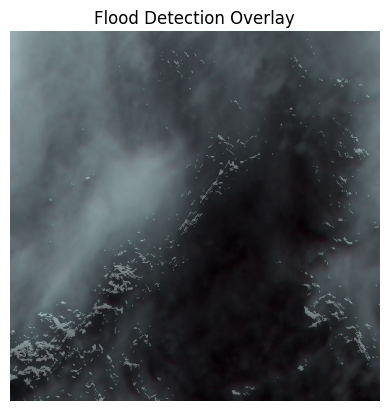

Estimated Chance of Flooding (SVM): 58.50%


In [30]:
import requests
import json
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from google.colab import files
from vonage import Vonage, Auth
from vonage_sms import SmsMessage

# uploaded = files.upload()
df = pd.read_csv('extended_flood_data.csv')


NASA_API_KEY = '2gq990VUavPLf9uQqDBEdKR3XpTDqDxlPCekpaGr'
longitude = 91.88
latitude = 24.89
date = '2022-06-20'
dim = 0.1
print(f"📍 Location: https://www.google.com/maps?q={latitude},{longitude}")


url = "https://api.nasa.gov/planetary/earth/assets"
params = {
    'lon': longitude,
    'lat': latitude,
    'date': date,
    'dim': dim,
    'api_key': NASA_API_KEY
}

response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()
    image_url = data.get('url')

    if image_url:
        print("Satellite Image URL:", image_url)
        try:
            image_response = requests.get(image_url)
            image_response.raise_for_status()
            image = Image.open(BytesIO(image_response.content))
            image = np.array(image)
            image_resized = cv2.resize(image, (512, 512))
            image_blurred = cv2.GaussianBlur(image_resized, (5, 5), 0)
            image_normalized = cv2.normalize(image_blurred, None, 0, 255, cv2.NORM_MINMAX)

            plt.imshow(cv2.cvtColor(image_normalized, cv2.COLOR_BGR2RGB))
            plt.title(f"Preprocessed Flood Image - {date}")
            plt.axis('off')
            plt.show()

            hsv_image = cv2.cvtColor(image_normalized, cv2.COLOR_BGR2HSV)
            lower_blue = np.array([90, 50, 50])
            upper_blue = np.array([130, 255, 255])
            flood_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)
            flood_result = cv2.bitwise_and(image_normalized, image_normalized, mask=flood_mask)

            plt.imshow(cv2.cvtColor(flood_result, cv2.COLOR_BGR2RGB))
            plt.title('Detected Flooded Areas')
            plt.axis('off')
            plt.show()

            plt.figure(figsize=(14, 6))
            plt.plot(df['Date'], df['Rainfall (mm)'], label='Rainfall (mm)', color='blue')
            plt.plot(df['Date'], df['Surma River Level(cm above danger line)'], label='Surma River Level (cm)', color='orange')
            plt.title('Rainfall and River Levels Over Time')
            plt.xlabel('Date')
            plt.ylabel('Measurement')
            plt.legend()
            plt.grid()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            df = pd.get_dummies(df, columns=['Soil Moisture Condition'], drop_first=True)
            # df['Flood'] = np.where((df['Rainfall (mm)'] > 60) | (df['Surma River Level(cm above danger line)'] > 60), 1, 0)
            df['Flood'] = np.where((df['Rainfall (mm)'] > 60) | (df['Surma River Level(cm above danger line)'] > 60), 1, 0)
            noise_fraction = 0.1
            n_samples = int(noise_fraction * len(df))
            flip_indices = random.sample(range(len(df)), n_samples)
            df.loc[flip_indices, 'Flood'] = 1 - df.loc[flip_indices, 'Flood']

            X = df[['Rainfall (mm)', 'Surma River Level(cm above danger line)'] + list(df.columns[df.columns.str.contains('Soil Moisture Condition_')])]
            y = df['Flood']

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            accuracy = accuracy_score(y_test, y_pred)
            print('Model Accuracy (SVM):', accuracy)

            cm = confusion_matrix(y_test, y_pred)
            print('Confusion Matrix:')
            print(cm)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.show()

            overlay = cv2.addWeighted(image_normalized, 0.7, cv2.cvtColor(flood_mask, cv2.COLOR_GRAY2BGR), 0.3, 0)
            plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
            plt.title('Flood Detection Overlay')
            plt.axis('off')
            plt.show()

            flood_chance = model.predict(X_test)
            flood_chance_percentage = np.mean(flood_chance) * 100
            print(f"Estimated Chance of Flooding (SVM): {flood_chance_percentage:.2f}%")
            if flood_chance_percentage > 50:
              auth = Auth(api_key="83ca0e9e", api_secret="ARQaTJ67DBeO1Uuv")
              client = Vonage(auth=auth)

              to = "919004279309"
              message = SmsMessage(
                  to=to,
                  from_="Vonage APIs",
                  text=" Flood Alert: A disaster has been predicted in your area. Stay alert and follow official evacuation instructions."
              )

              response = client.sms.send(message)

              if response.messages[0].status == "0":
                  print(f"Message sent to {to}  successfully.")
              else:
                  print(f" Message failed with error: {response.messages[0].error_text}")
              evacuation_url = "https://www.ready.gov/evacuation"
              display(HTML(f'<script>window.open("{evacuation_url}", "_blank");</script>'))

        except Exception as e:
            print(f"Error displaying the image: {e}")
    else:
        print("No image available for the given location and date.")
else:
    print(f"Failed to fetch data from NASA API. Status code: {response.status_code}")


Hurricanes(same logic and functionalities used as used for flood detection)
to predict the chances of hurricane occuring before it actually occurs in Ida, Louisiana on August 2021 by applying machine laerning models to enviornment conditions prior to the incident and satellite images.

Saving weather_data_1000_records.csv to weather_data_1000_records (2).csv
Hurricane Satellite Image URL: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/51c32980998e0d4ab56938350110eeef-c83e2ae2f2b637e0e9da627273839d84:getPixels


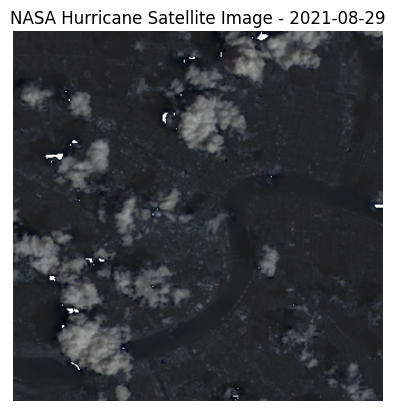

Hurricane Prediction Model Accuracy: 0.895
Hurricane Confusion Matrix:
[[96 12]
 [ 9 83]]


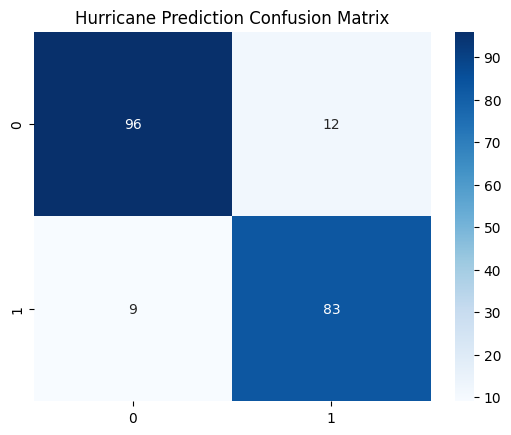

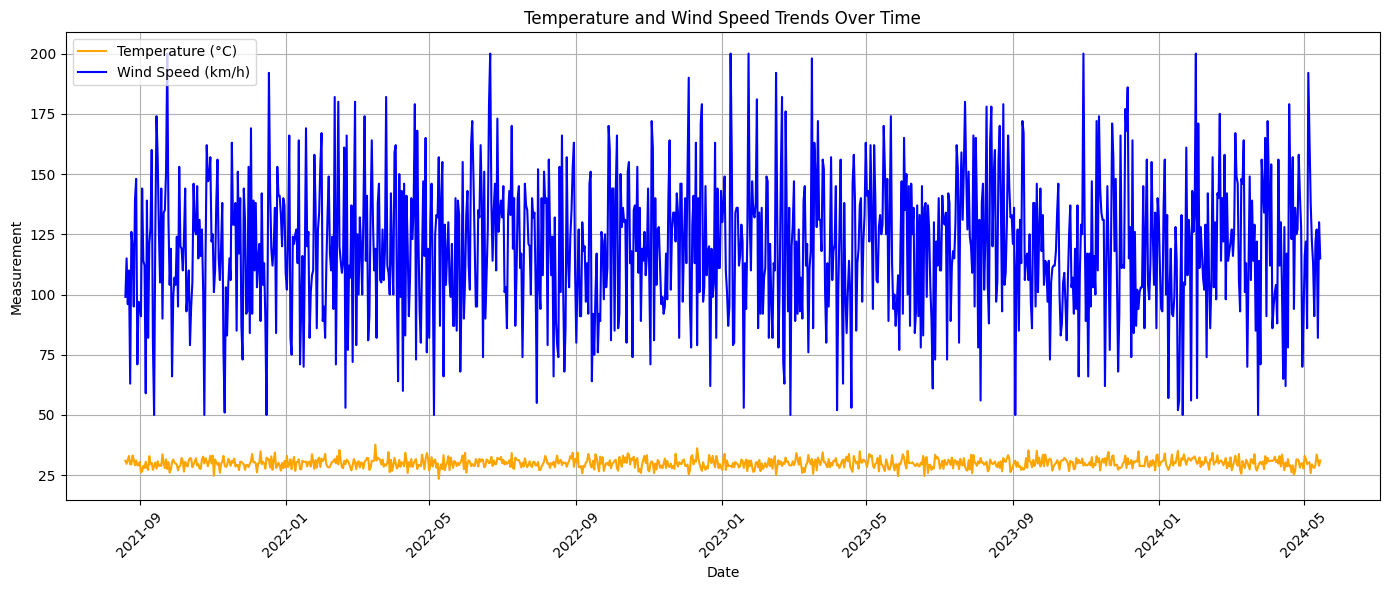

Estimated Chance of Hurricane Occurring: 47.50%


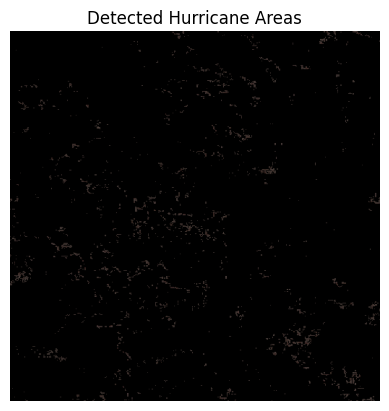

In [24]:
import requests
import json
import random
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import cv2
from vonage import Vonage, Auth
from vonage_sms import SmsMessage
from google.colab import files

NASA_API_KEY = '2gq990VUavPLf9uQqDBEdKR3XpTDqDxlPCekpaGr'

uploaded = files.upload()
df = pd.read_csv('weather_data_1000_records.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')


longitude = -90.07
latitude = 29.95
date = '2021-08-29'
dim = 0.1
print(f"📍 Location: https://www.google.com/maps?q={latitude},{longitude}")

url = "https://api.nasa.gov/planetary/earth/assets"
params = {
    'lon': longitude,
    'lat': latitude,
    'date': date,
    'dim': dim,
    'api_key': NASA_API_KEY
}

response = requests.get(url, params=params)
if response.status_code == 200:
    data = response.json()
    image_url = data.get('url')

    if image_url:
        print("Hurricane Satellite Image URL:", image_url)
        try:
            image_response = requests.get(image_url)
            image_response.raise_for_status()
            image = Image.open(BytesIO(image_response.content))
            image_resized = cv2.resize(np.array(image), (512, 512))
            plt.imshow(image)
            plt.title(f"NASA Hurricane Satellite Image - {date}")
            plt.axis('off')
            plt.show()
            # df['Hurricane'] = np.where(df['Wind Speed (km/h)'] > 120, 1, 0)
            df['Hurricane'] = np.where(df['Wind Speed (km/h)'] > 120, 1, 0)
            noise_fraction = 0.1
            n_samples = int(noise_fraction * len(df))
            flip_indices = random.sample(range(len(df)), n_samples)
            df.loc[flip_indices, 'Hurricane'] = 1 - df.loc[flip_indices, 'Hurricane']

            X = df[['Temperature (°C)', 'Humidity (%)', 'Wind Speed (km/h)']]
            y = df['Hurricane']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            print('Hurricane Prediction Model Accuracy:', accuracy)
            cm = confusion_matrix(y_test, y_pred)
            print('Hurricane Confusion Matrix:')
            print(cm)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Hurricane Prediction Confusion Matrix')
            plt.show()
            plt.figure(figsize=(14, 6))
            plt.plot(df['Date'], df['Temperature (°C)'], label='Temperature (°C)', color='orange')
            plt.plot(df['Date'], df['Wind Speed (km/h)'], label='Wind Speed (km/h)', color='blue')
            plt.title('Temperature and Wind Speed Trends Over Time')
            plt.xlabel('Date')
            plt.ylabel('Measurement')
            plt.legend()
            plt.grid()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            hurricane_chance = model.predict(X_test)
            hurricane_chance_percentage = np.mean(hurricane_chance) * 100
            if hurricane_chance_percentage > 50:
              auth = Auth(api_key="83ca0e9e", api_secret="ARQaTJ67DBeO1Uuv")
              client = Vonage(auth=auth)

              to = "919004279309"
              message = SmsMessage(
                  to=to,
                  from_="Vonage APIs",
                  text=" Flood Alert: A disaster has been predicted in your area. Stay alert and follow official evacuation instructions."
              )

              response = client.sms.send(message)

              if response.messages[0].status == "0":
                  print(f"Message sent to {to}  successfully.")
              else:
                  print(f" Message failed with error: {response.messages[0].error_text}")
              evacuation_url = "https://www.ready.gov/evacuation"
              display(HTML(f'<script>window.open("{evacuation_url}", "_blank");</script>'))
            print(f"Estimated Chance of Hurricane Occurring: {hurricane_chance_percentage:.2f}%")
            hsv_image = cv2.cvtColor(image_resized, cv2.COLOR_BGR2HSV)
            lower_hurricane = np.array([0, 50, 50])
            upper_hurricane = np.array([10, 255, 255])
            hurricane_mask = cv2.inRange(hsv_image, lower_hurricane, upper_hurricane)
            hurricane_result = cv2.bitwise_and(image_resized, image_resized, mask=hurricane_mask)
            plt.imshow(cv2.cvtColor(hurricane_result, cv2.COLOR_BGR2RGB))
            plt.title('Detected Hurricane Areas')
            plt.axis('off')
            plt.show()


        except Exception as e:
            print(f"Error processing hurricane image: {e}")
    else:
        print("No hurricane image available for the given location and date.")
else:
    print(f"Failed to fetch hurricane data from NASA API. Status code: {response.status_code}")


Earthquakes(same logic and functionalities used as used for flood detection)
to predict the chances of eathquake occuring before it actually occurs in turjey,Syria on Feburary 2023 by applying machine laerning models to enviornment conditions prior to the incident and satellite images.

📍 Location: https://www.google.com/maps?q=36.5,37.66
Earthquake Satellite Image URL: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a4f61cb79a9da5fc275a9b29cba298e9-7168d0ce9fa581aa926327d3bfb03d2c:getPixels


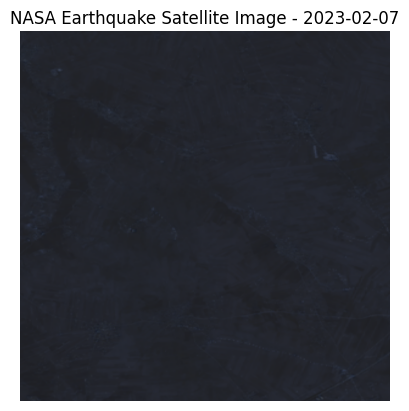

Earthquake Prediction Model Accuracy: 0.925
Earthquake Confusion Matrix:
[[ 59  11]
 [  4 126]]


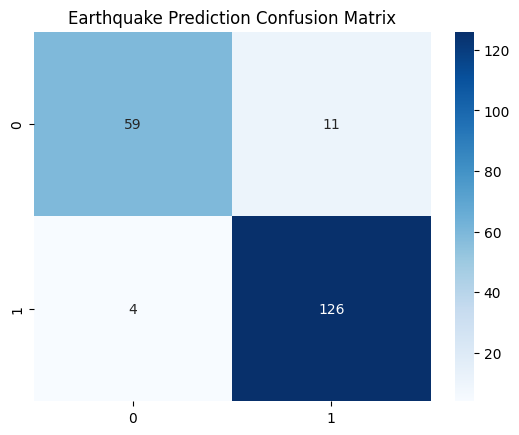

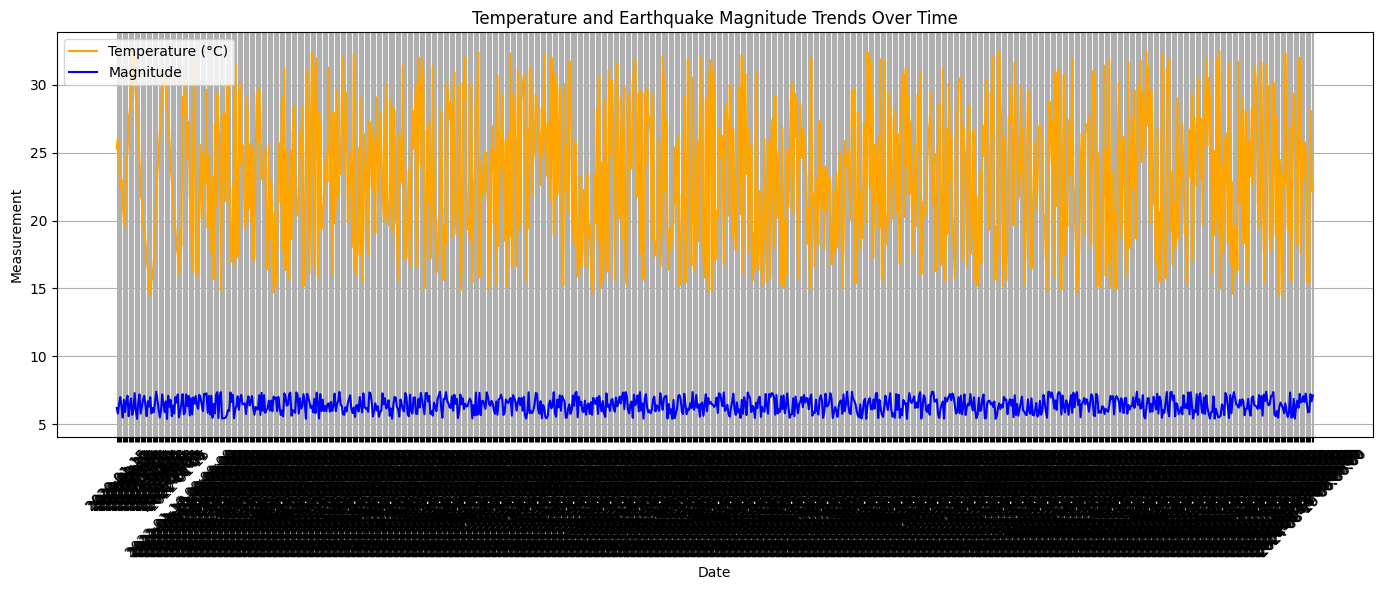

Message sent to 919004279309  successfully.


Estimated Chance of Earthquake Occurring: 68.50%


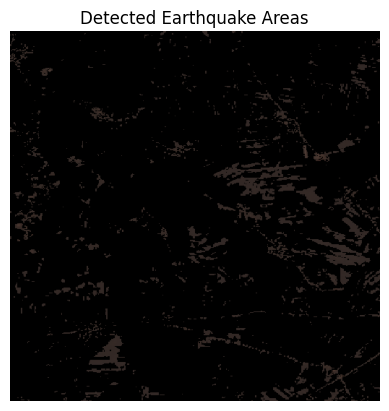

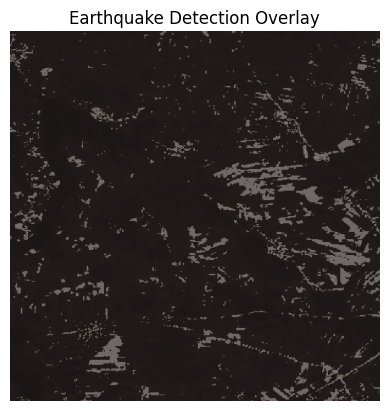

In [45]:
import requests
import json
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import cv2
from vonage import Vonage, Auth
from vonage_sms import SmsMessage
from google.colab import files

NASA_API_KEY = '2gq990VUavPLf9uQqDBEdKR3XpTDqDxlPCekpaGr'
# uploaded = files.upload()
df = pd.read_csv('earthquake_updated.csv')

longitude = 37.66
latitude = 36.50
date = '2023-02-07'
dim = 0.1
print(f"📍 Location: https://www.google.com/maps?q={latitude},{longitude}")

url = "https://api.nasa.gov/planetary/earth/assets"
params = {
    'lon': longitude,
    'lat': latitude,
    'date': date,
    'dim': dim,
    'api_key': NASA_API_KEY
}
response = requests.get(url, params=params)
if response.status_code == 200:
    data = response.json()
    image_url = data.get('url')

    if image_url:
        print("Earthquake Satellite Image URL:", image_url)
        try:
            image_response = requests.get(image_url)
            image_response.raise_for_status()
            image = Image.open(BytesIO(image_response.content))
            image_resized = cv2.resize(np.array(image), (512, 512))
            plt.imshow(image)
            plt.title(f"NASA Earthquake Satellite Image - {date}")
            plt.axis('off')
            plt.show()
            df['Earthquake'] = np.where(df['Magnitude'] > 6.0, 1, 0)
            noise_fraction = 0.1
            n_samples = int(noise_fraction * len(df))
            flip_indices = random.sample(range(len(df)), n_samples)
            df.loc[flip_indices, 'Earthquake'] = 1 - df.loc[flip_indices, 'Earthquake']
            X = df[['Temperature (°C)', 'Humidity (%)', 'Magnitude']]
            y = df['Earthquake']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            print('Earthquake Prediction Model Accuracy:', accuracy)
            cm = confusion_matrix(y_test, y_pred)
            print('Earthquake Confusion Matrix:')
            print(cm)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Earthquake Prediction Confusion Matrix')
            plt.show()
            plt.figure(figsize=(14, 6))
            plt.plot(df['Date'], df['Temperature (°C)'], label='Temperature (°C)', color='orange')
            plt.plot(df['Date'], df['Magnitude'], label='Magnitude', color='blue')
            plt.title('Temperature and Earthquake Magnitude Trends Over Time')
            plt.xlabel('Date')
            plt.ylabel('Measurement')
            plt.legend()
            plt.grid()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            earthquake_chance = model.predict(X_test)
            earthquake_chance_percentage = np.mean(earthquake_chance) * 100
            if earthquake_chance_percentage > 50:
              auth = Auth(api_key="83ca0e9e", api_secret="ARQaTJ67DBeO1Uuv")
              client = Vonage(auth=auth)

              to = "919004279309"
              message = SmsMessage(
                  to=to,
                  from_="Vonage APIs",
                  text=" Flood Alert: A disaster has been predicted in your area. Stay alert and follow official evacuation instructions."
              )

              response = client.sms.send(message)

              if response.messages[0].status == "0":
                  print(f"Message sent to {to}  successfully.")
              else:
                  print(f" Message failed with error: {response.messages[0].error_text}")
              evacuation_url = "https://www.ready.gov/evacuation"
              display(HTML(f'<script>window.open("{evacuation_url}", "_blank");</script>'))
            print(f"Estimated Chance of Earthquake Occurring: {earthquake_chance_percentage:.2f}%")
            hsv_image = cv2.cvtColor(image_resized, cv2.COLOR_BGR2HSV)
            lower_earthquake = np.array([0, 50, 50])
            upper_earthquake = np.array([10, 255, 255])
            earthquake_mask = cv2.inRange(hsv_image, lower_earthquake, upper_earthquake)
            earthquake_result = cv2.bitwise_and(image_resized, image_resized, mask=earthquake_mask)
            plt.imshow(cv2.cvtColor(earthquake_result, cv2.COLOR_BGR2RGB))
            plt.title('Detected Earthquake Areas')
            plt.axis('off')
            plt.show()
            overlay_mask = np.where(earthquake_mask > 0, 1, 0).astype(np.uint8)
            overlay = cv2.addWeighted(image_resized, 0.7, cv2.cvtColor(overlay_mask * 255, cv2.COLOR_GRAY2BGR), 0.3, 0)
            plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
            plt.title('Earthquake Detection Overlay')
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Error processing earthquake image: {e}")
    else:
        print("No earthquake image available for the given location and date.")
else:
    print(f"Failed to fetch earthquake data from NASA API. Status code: {response.status_code}")
